In [307]:
#Librerias
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score,confusion_matrix,roc_curve
import seaborn as sns

In [308]:
# Se lee la base de datos y se imprimen los datos más relevantes de esta 
dataHeartDisese = pd.read_csv('heart.csv')
print(dataHeartDisese.columns)
dataHeartDisese.head(10)
# Se tienen 11 caracteristicas de las cuales 5 son categoricas y 6 son numericas

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [309]:
#Se separan las columnas categoricas y numericas
Categoricas = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']
Numericas = ['Age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak']
#Se buscan valores unicos, es decir, los valores que puede tomar cada categoria.
for col in Categoricas:
    print("La categoria", col, "puede tomar los valores de:",dataHeartDisese[col].unique())

print(Numericas)

La categoria Sex puede tomar los valores de: ['M' 'F']
La categoria ChestPainType puede tomar los valores de: ['ATA' 'NAP' 'ASY' 'TA']
La categoria RestingECG puede tomar los valores de: ['Normal' 'ST' 'LVH']
La categoria ExerciseAngina puede tomar los valores de: ['N' 'Y']
La categoria ST_Slope puede tomar los valores de: ['Up' 'Flat' 'Down']
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']


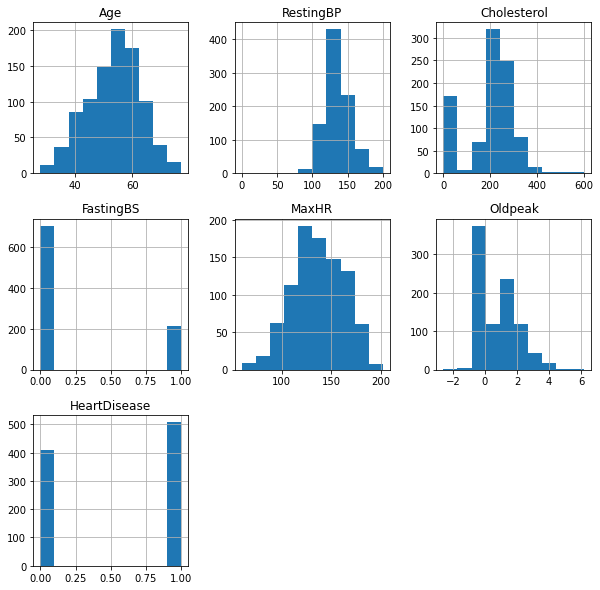

In [310]:
dataHeartDisese.hist(figsize=(10,10))
plt.show()
# Se observa en el Histograma que en la columna de Colesterol hay muchos valores fuera de tendencia sobre cero
#  esto puede ser que son datos que fueron perdidos y se remplazaron por cero

In [311]:
dataHeartDisese.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [312]:
# Para facilitar el trabajo no se trabajara con la Columna de Cholesterol, muchos valores fuera de tendencia dificultan la predicción.
# Adicionalmente hay muchos outliers en OldPeak,RestingBP y FastingBS, el clasificador podría hacer overfitting en estos casos
# Una solución puede ser remplazar los outliers con valores medios y de esta forma balancear la base de datos
# ver https://www.pluralsight.com/guides/cleaning-up-data-from-outliers
# Se procede a remplazar los valores categoricos por valores numericos, dado que no tienen orden se eligen numeros enteros consecutivos
# M ---> 0 F ---> 1
# N ---> 0 Y ---> 1
# Up --> 0 Flat --> 1 Down --> 2
# Normal --> 0 ST --> 1 LVH--> 2
# ATA --> 0 NAP --> 1 ASY --> 2 TA --> 2

cat_binarias = { "Sex": {"M": 0, "F": 1},
                 "ExerciseAngina": {"N": 0,"Y": 1},
                 "ChestPainType": {"ATA": 0,"NAP": 1,"ASY": 2,"TA":2},
                 "ST_Slope": {"Up": 0,"Flat": 1,"Down": 2},
                 "RestingECG": {"Normal": 0,"ST": 1,"LVH": 2}}

Categoricas = dataHeartDisese.replace(cat_binarias)
del Categoricas["Cholesterol"]
Categoricas.head()


,Age,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,0,0,140,0,0,172,0,0.0,0,0
1,49,1,1,160,0,0,156,0,1.0,1,1
2,37,0,0,130,0,1,98,0,0.0,0,0
3,48,1,2,138,0,0,108,1,1.5,1,1
4,54,0,1,150,0,0,122,0,0.0,0,0


In [313]:
# Se imprimen los valores que equivalen a la media de cada categoria, y los valores mayores al 95% de la categoria
print(dataHeartDisese['Oldpeak'].quantile(0.50)) 
print(dataHeartDisese['Oldpeak'].quantile(0.95)) 
print(dataHeartDisese['RestingBP'].quantile(0.50)) 
print(dataHeartDisese['RestingBP'].quantile(0.95)) 
print(dataHeartDisese['FastingBS'].quantile(0.50)) 
print(dataHeartDisese['FastingBS'].quantile(0.95)) 


0.6
3.0
130.0
160.0
0.0
1.0


In [314]:
# Los valores mayores al 95% de la categoria se remplazan con la media 
Categoricas['Oldpeak'] = np.where(Categoricas['Oldpeak'] > 3.0, 0.6, Categoricas['Oldpeak'])
Categoricas['RestingBP'] = np.where(Categoricas['RestingBP'] > 160, 130, Categoricas['RestingBP'])
Categoricas['FastingBS'] = np.where(Categoricas['FastingBS'] > 1.0, 0, Categoricas['FastingBS'])
Categoricas.describe()

,Age,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.210240,1.401961,130.160131,0.233115,0.603486,136.809368,0.404139,0.785621,0.638344,0.553377
std,9.432617,0.407701,0.786109,15.401619,0.423046,0.805968,25.460334,0.490992,0.912060,0.607056,0.497414
min,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,0.000000,1.000000,120.000000,0.000000,0.000000,120.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,0.000000,2.000000,130.000000,0.000000,0.000000,138.000000,0.000000,0.600000,1.000000,1.000000
75%,60.000000,0.000000,2.000000,140.000000,0.000000,1.000000,156.000000,1.000000,1.500000,1.000000,1.000000
max,77.000000,1.000000,2.000000,160.000000,1.000000,2.000000,202.000000,1.000000,3.000000,2.000000,1.000000


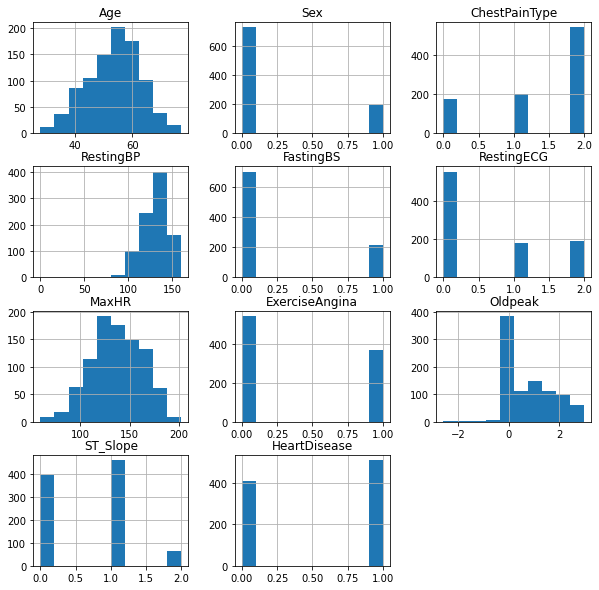

In [315]:
Categoricas.hist(figsize=(10,10))
plt.show()

In [316]:
#Con los valores ya limpios se divide la base de datos en etiqueta de salida y caracteristicas
etiqueta = dataHeartDisese.iloc[:,11].values
caracteristicas = Categoricas.iloc[:,:11].values
print(etiqueta.shape)
print(caracteristicas.shape)


(918,)
(918, 11)


In [317]:
#Se divide la base de datos en datos de entrenamiento(80%) y datos de validación(20%) 
car_train,car_test,etiq_train,etiq_test = train_test_split (caracteristicas,etiqueta,test_size=0.2)
print("Train: ",car_train.shape, etiq_train.shape)
print("Test: ",car_test.shape, etiq_test.shape)

Train:  (734, 11) (734,)
Test:  (184, 11) (184,)


In [318]:
# Escalizar los datos 
sc = StandardScaler()
car_train = sc.fit_transform(car_train)
car_test = sc.transform(car_test)

In [319]:
# Se definen algunas funciones para facilitar la comparación de los resultados de los modelos
# Para optimizar los hiperparametros se hace un Grid Search, 
# ver https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657
# ver https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
def Optimize(classifier, params,X_train, y_train, cv=5 ):
    grid = GridSearchCV(classifier, params, cv=KFold(n_splits=cv), n_jobs=1, verbose=1, return_train_score=True, scoring='accuracy', refit=True) 
    grid.fit(X_train, y_train)
    return grid
# De la funcion de GridSearch también se extraen los mejores puntajes obtenidos y los mejores parametros.
def best_scores(model):
    print(f'Los mejores parametros obtenidos son {model.best_params_}')
    print(f'El mejor puntaje de accuracy obtenido es:{model.best_score_}')

# Se crea un funcion que imprime en el terminal las métricas usadas F1,ROC-AUC SCORE Y MCC
def metrics(y_pred,y_test):
    print("El puntaje F1 :", f1_score(y_test, y_pred))
    print("El puntaje ROC-AUC:",roc_auc_score(y_test,y_pred))
    print("El coeficien de correlación de Matthews:",matthews_corrcoef(y_test,y_pred))
    
#ver https://www.kaggle.com/sanchman/heart-failure-prediction-91-rec-88-acc-89-f1
def plot_confusion_matrix(y_pred,y_test):
    print('00: True Negatives\n01: False Positives\n10: False Negatives\n11: True Positives\n')
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap='GnBu', alpha=0.75)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large') 
    plt.xlabel('Predictions', fontsize=14)
    plt.ylabel('Actuals', fontsize=14)
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()
    
def plot_ROC_curve(y_pred,y_test):
    fpr, tpr, thresholds = roc_curve(y_test,y_pred, pos_label=1)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test,y_pred))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic. ROC')
    plt.legend(loc="lower right")
    plt.show()


In [320]:
# Se implementa el clasificador de Regresión Logística, para lo cual se utilizan varios parametros
# Y obtener los mejores con GrindSeach
lr_params = {'C':[0.001,.009,0.01,.09,0.9,1,9,10,9], 'penalty':['l1', 'l2']} #regularizacion lasso y rigde
clf = LogisticRegression(random_state=100, solver='liblinear', max_iter=1000000)
lr_model = Optimize(clf, lr_params,car_train,etiq_train)
best_scores(lr_model)
etiq_pred=lr_model.predict(car_test)
metrics(etiq_pred,etiq_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Los mejores parametros obtenidos son {'C': 0.009, 'penalty': 'l1'}
El mejor puntaje de accuracy obtenido es:1.0
El puntaje F1 : 1.0
El puntaje ROC-AUC: 1.0
El coeficien de correlación de Matthews: 1.0


00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



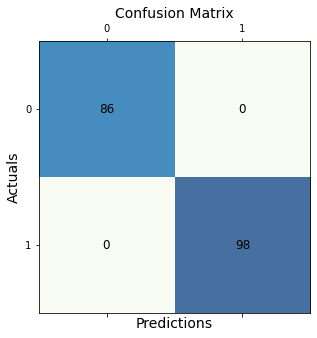

In [321]:
# Se grafica la matriz de confusion
plot_confusion_matrix(etiq_pred,etiq_test)

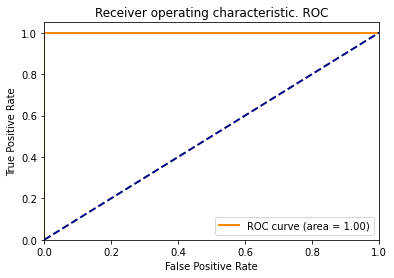

In [322]:
# Se gráfica la curva  ROC
plot_ROC_curve(etiq_pred,etiq_test)

In [323]:
# Se implementa el modelo de KNN, donde se le ingresan varios paramatros para K
# y los pesos, se utiliza GridSearch para obtener los mejores
distance='euclidean'
KNN_param = { 'n_neighbors' : [1,3,5,9,11,13,17,19],
               'weights' : ['uniform','distance'],
               'metric' : [distance]}
               
knn = KNeighborsClassifier( metric_params=None,algorithm='brute')
knn_model = Optimize(knn, KNN_param,car_train,etiq_train)
best_scores(knn_model)
etiq_pred=knn_model.predict(car_test)
metrics(etiq_pred,etiq_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Los mejores parametros obtenidos son {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
El mejor puntaje de accuracy obtenido es:0.9809244245643463
El puntaje F1 : 1.0
El puntaje ROC-AUC: 1.0
El coeficien de correlación de Matthews: 1.0


00: True Negatives
01: False Positives
10: False Negatives
11: True Positives



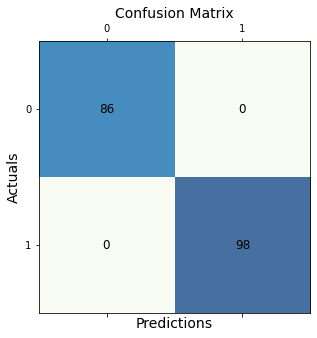

In [324]:
# Se grafica la matriz de confusion
plot_confusion_matrix(etiq_pred,etiq_test)

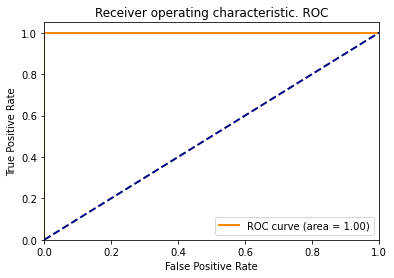

In [325]:
# Se grafica la curva ROC
plot_ROC_curve(etiq_pred,etiq_test)